In [1]:
import cupy as cp
import numpy as np
import pandas as pd
from types import SimpleNamespace

from utils import *
from rec_gpu import Rec
cp.cuda.Device(2).use()

<CUDA Device 2>

# Init data sizes and parametes of the PXM of ID16A

In [ ]:
n = 128  # object size in each dimension
ntheta = 180  # number of angles (rotations)
theta = np.linspace(0, np.pi, ntheta).astype('float32')  # projection angles

ndist = 4 # number of distances from the focal spot in holotomography
detector_pixelsize = 3e-6 # detector pixel size
energy = 33.35  # [keV] xray energy
wavelength = 1.2398419840550367e-09/energy  # [m] wave length

focusToDetectorDistance = 1.208  # focus to detector distance [m]
sx0 = -2.493e-3
z1 = np.array([1.5335e-3, 1.7065e-3, 2.3975e-3, 3.8320e-3])[:ndist]-sx0 # distances
# z1+=0.3e-3
z2 = focusToDetectorDistance-z1
distances = (z1*z2)/focusToDetectorDistance # adjusted distances
magnifications = focusToDetectorDistance/z1 # magnifications
voxelsize = detector_pixelsize/magnifications[0]*2048/n/2  # object voxel size

norm_magnifications = magnifications/magnifications[0] # normalized magnifications
distances = distances*norm_magnifications**2 # readjusted distances
npsi = int(np.ceil(n/norm_magnifications[-1]/8))*8  # reconstructed object size based on magnification and detector size


In [3]:
args = SimpleNamespace()
args.n = n
args.nq = n
args.ndist = ndist
args.ntheta = ntheta
args.npsi = npsi

args.voxelsize = voxelsize
args.wavelength = wavelength
args.distance = distances
# args.distancep = distancesp
args.rotation_axis = args.npsi/2

args.theta = theta
args.norm_magnifications = norm_magnifications
args.nchunk=128
args.ngpus=1
args.pad = 0

# create class
cl_rec = Rec(args)

## Read data

In [4]:
u=cp.load('u.npy')
nn = u.shape[-1]
u = u[nn//2-npsi//2:nn//2+npsi//2,nn//2-npsi//2:nn//2+npsi//2,nn//2-npsi//2:nn//2+npsi//2]

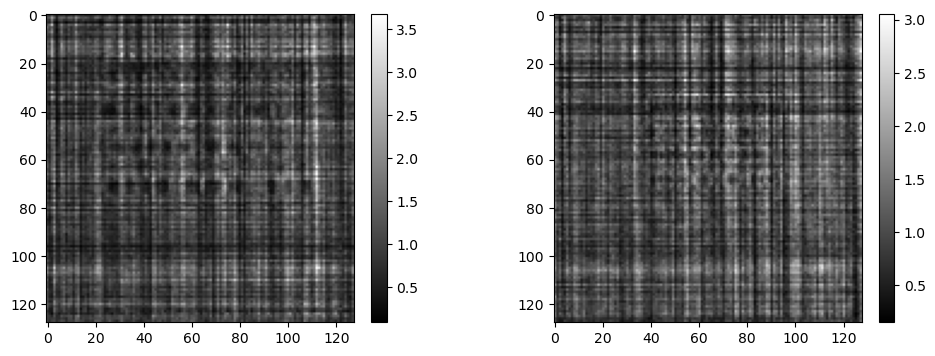

In [5]:
data = cp.load('data.npy')
ref = cp.load('ref.npy')
r = cp.load('shifts.npy')[:ntheta]
mshow_complex(data[0,0]+1j*data[0,-1],True)

# Back propagate probe for the intial guess

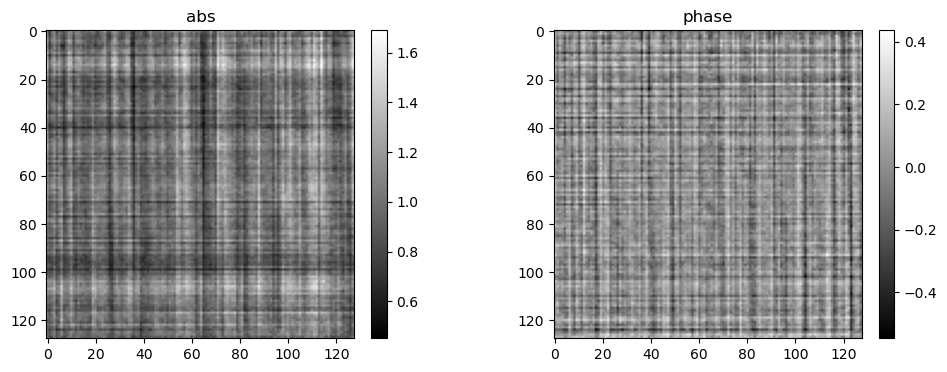

In [6]:
q_init = cp.ones([args.ndist,args.n,args.n],dtype='complex64')
for k in range(args.ndist):
    q_init[k] = cl_rec.DT(cp.sqrt(ref[k:k+1]).astype('complex64'),k)
mshow_polar(q_init[0],True)


# Reconstruct

0) err=1.59304e+04


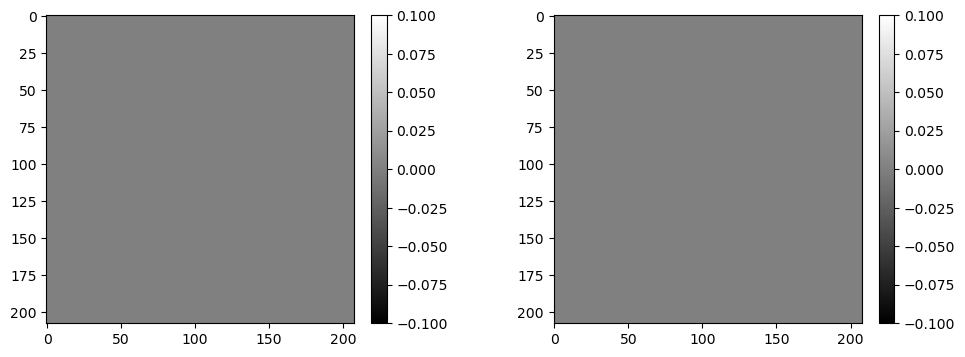

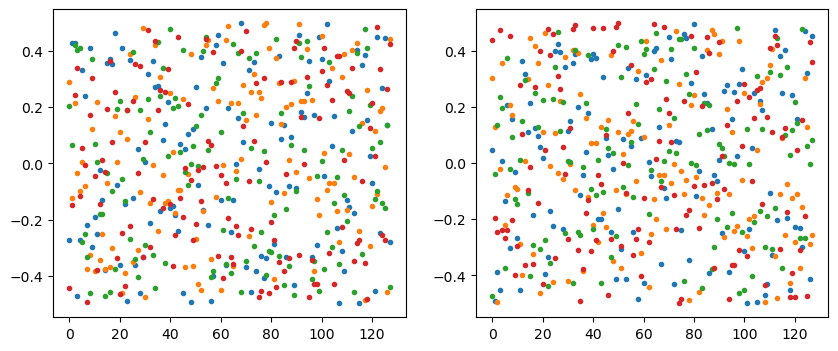

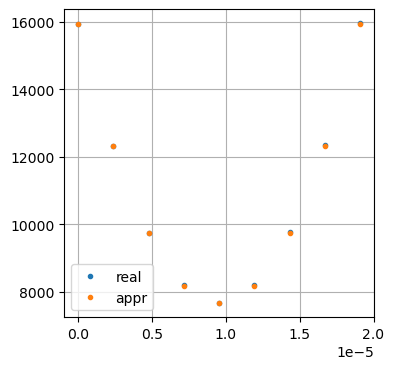

4) err=4.43335e+03


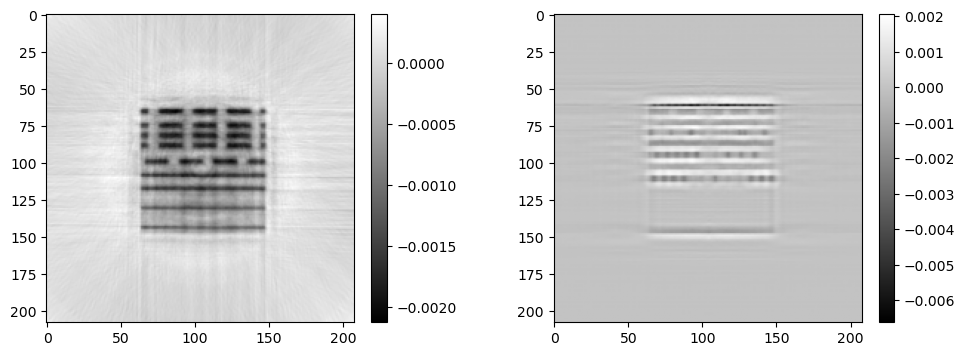

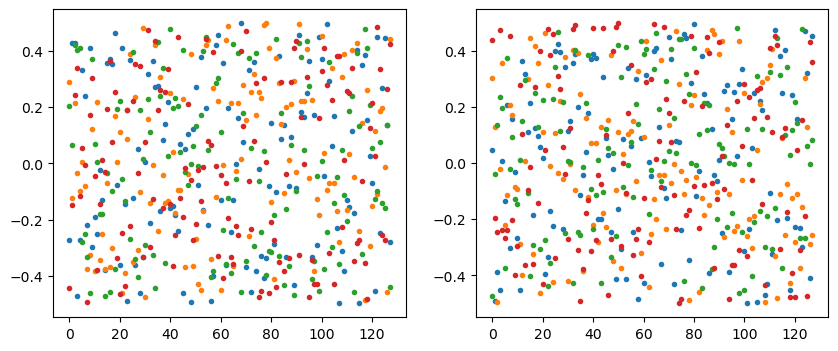

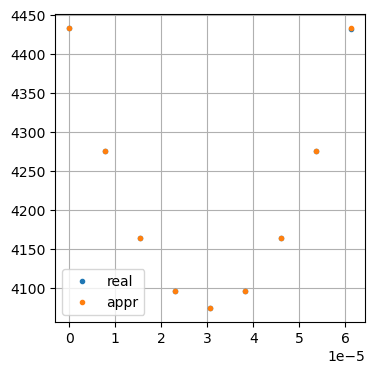

8) err=3.35699e+03


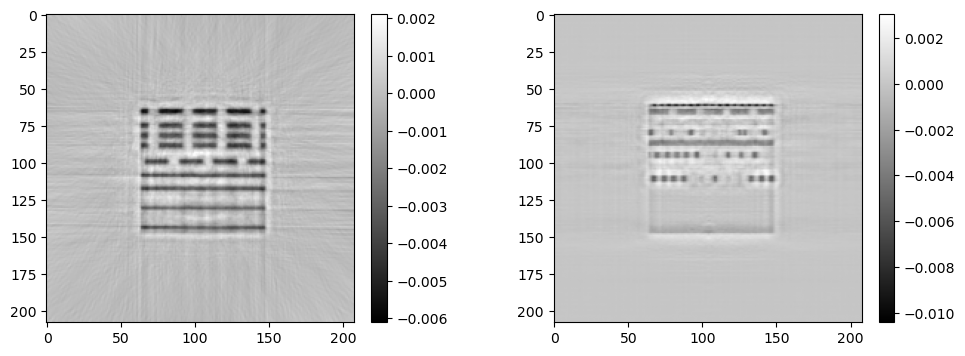

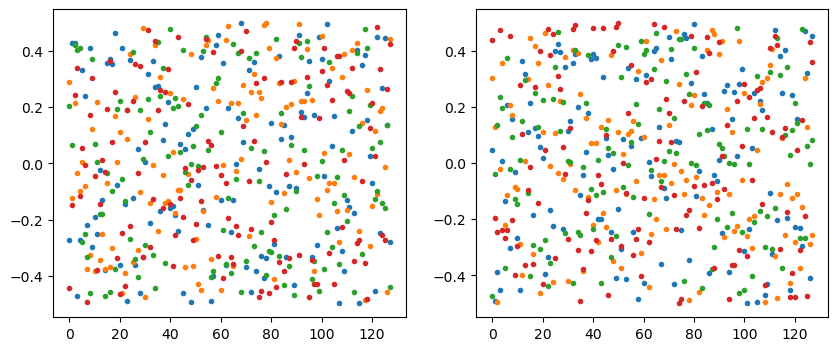

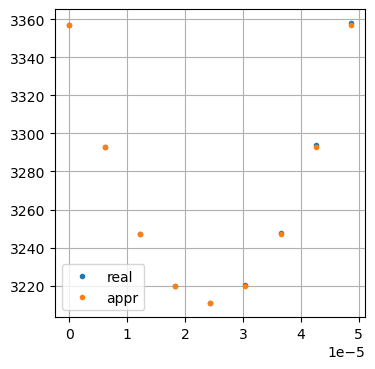

12) err=2.95676e+03


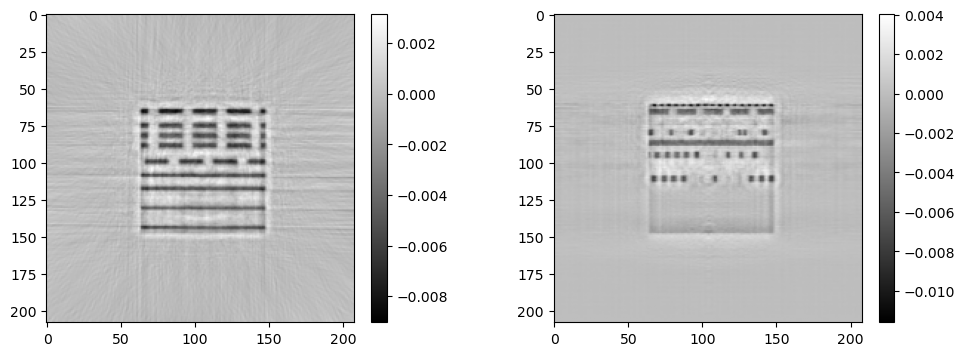

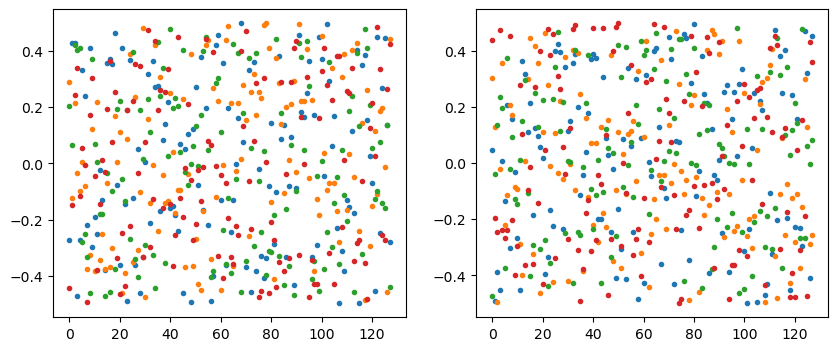

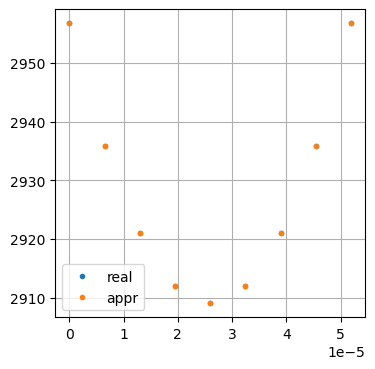

16) err=2.79567e+03


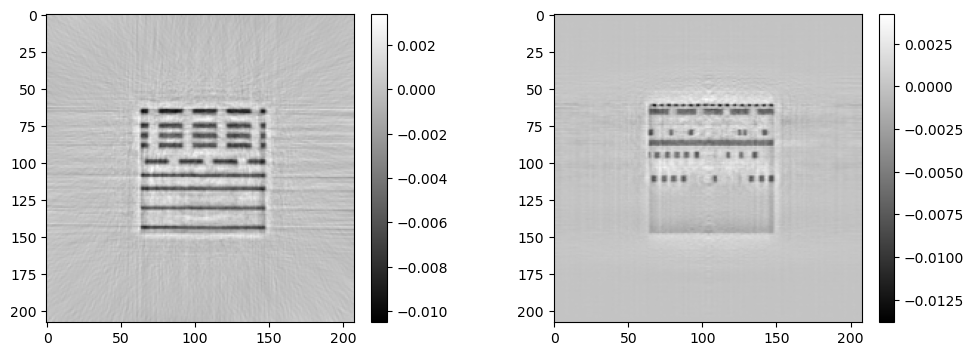

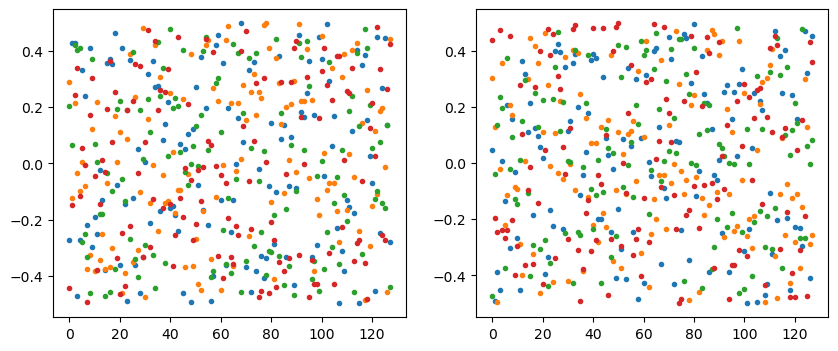

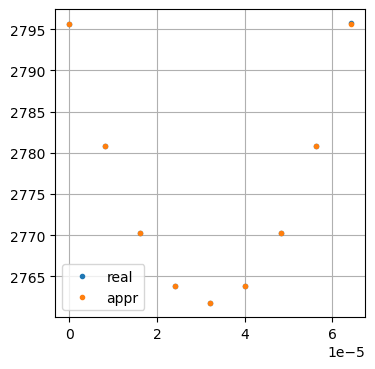

20) err=2.69220e+03


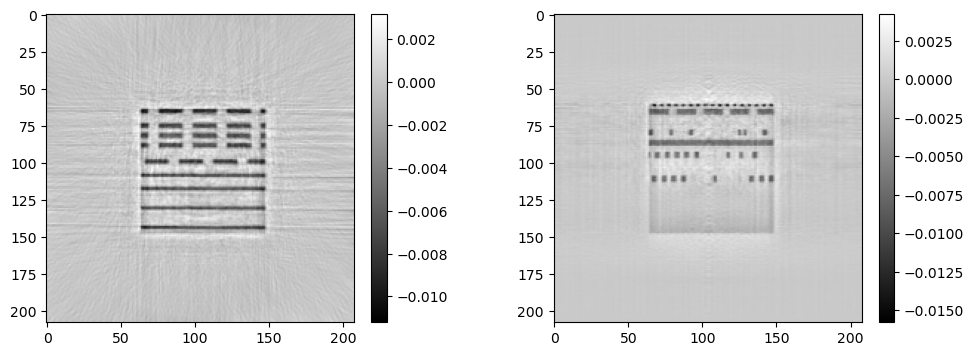

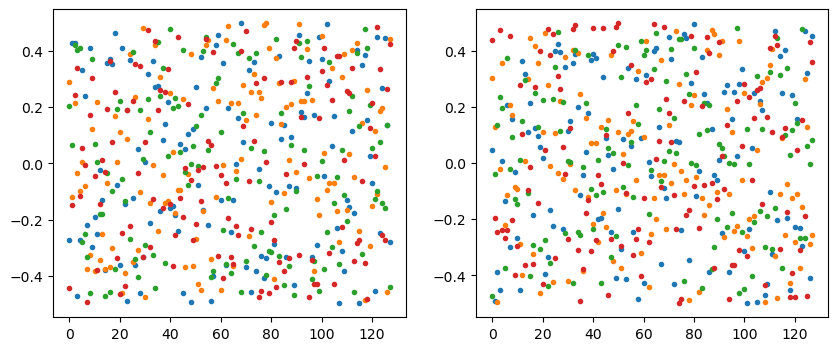

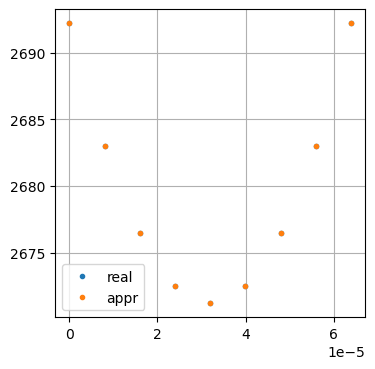

24) err=2.62345e+03


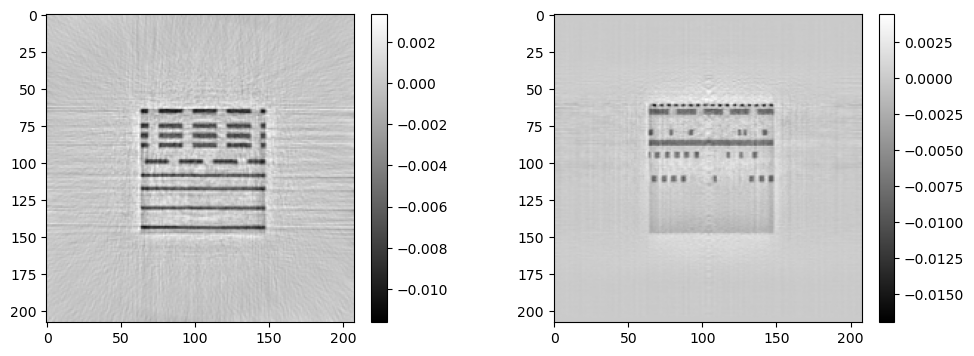

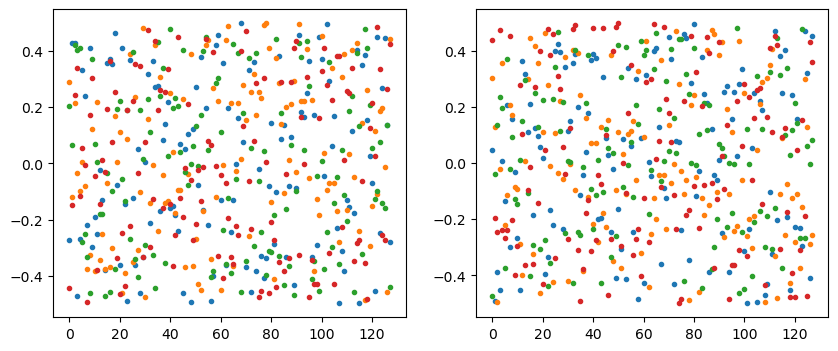

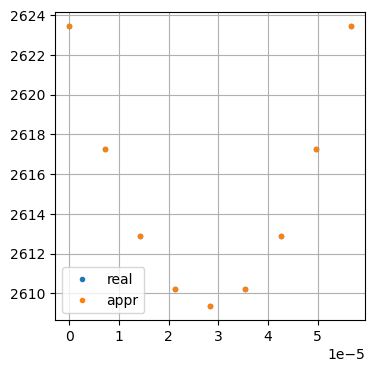

28) err=2.57392e+03


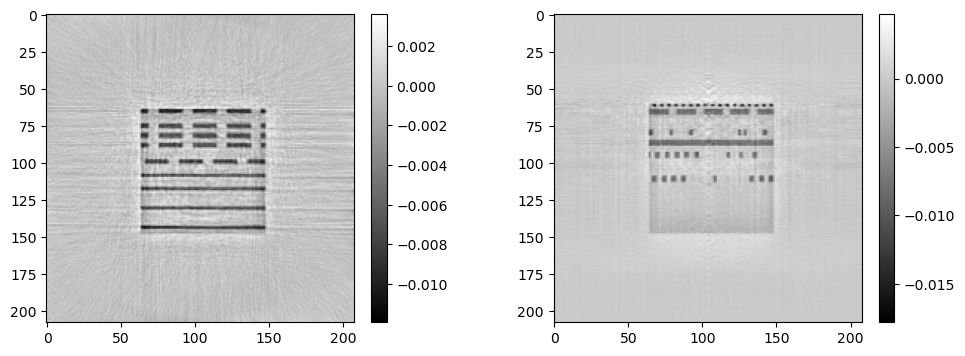

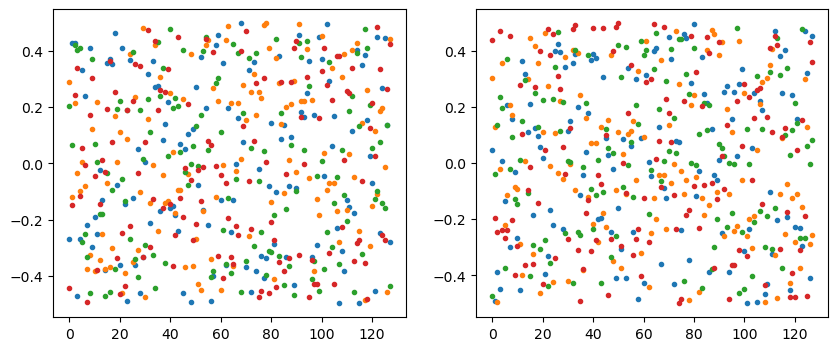

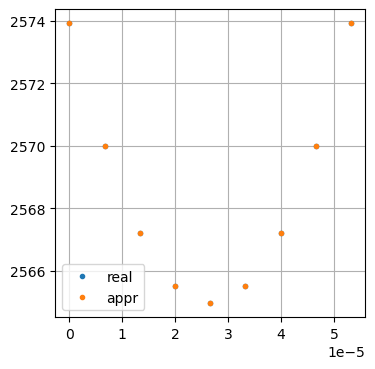

32) err=2.53670e+03


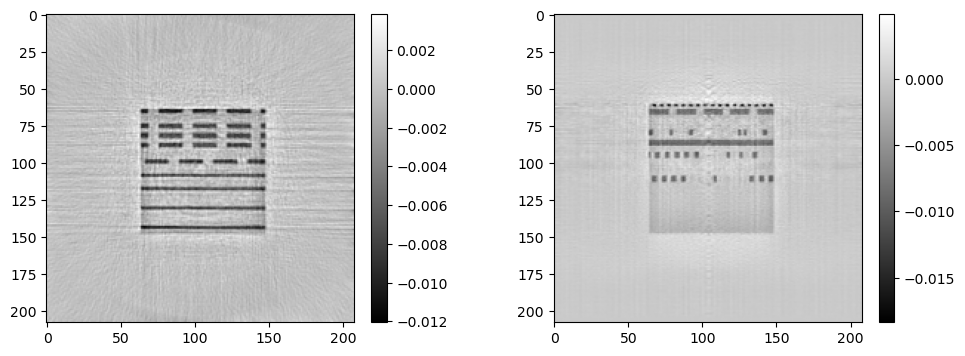

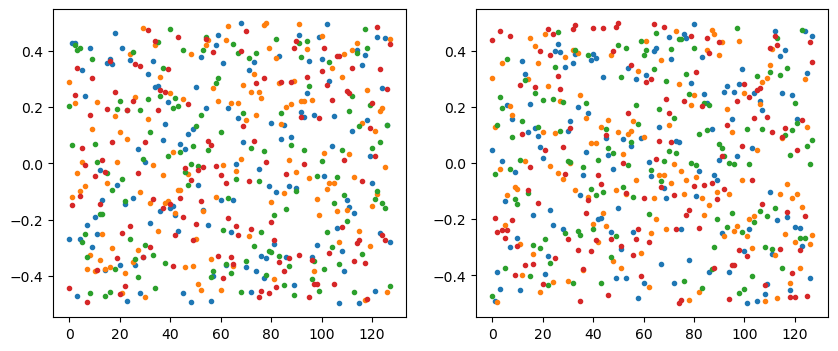

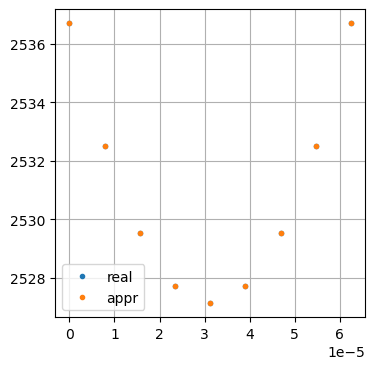

In [7]:

args.niter=33 # number of iters
args.vis_step=4 # show visualization step
args.err_step=4# show error step
args.path_out='/local/data/out00' # output forlder for dumped results for each vis step
args.show=True # show visualization or not
args.rho=[1,0.1,0.1] # scaling of variables to control the convergence
args.lam=0
args.eps=0
args.lamq = 0
cl_rec = Rec(args)

vars={}
vars["u"] = cp.zeros([npsi,npsi,npsi],dtype='complex64')

# q_init = cp.zeros([ndist,n,n],dtype='float32')
# for k in range(ndist):
#     q_init[k] = cp.angle(cl_rec.D(cp.load('q.npy')[k],k))

vars["q"] = q_init.copy()


vars["r"] = cp.load('shifts.npy')[:ntheta]
vars["r_init"] = cp.load('shifts.npy')[:ntheta]+cp.load('shifts_err.npy')[:ntheta]
vars["psi"] = cl_rec.R(vars['u'])        
vars["psi"][:] = cl_rec.expR(vars["psi"])        
vars["table"] = pd.DataFrame(columns=["iter", "err", "time"])  #monitor convregence

vars = cl_rec.BH(cp.sqrt(data),cp.sqrt(ref), vars)  



In [8]:
# args.niter=32 # number of iters
# args.vis_step=4 # show visualization step
# args.err_step=1# show error step
# args.path_out='/local/data/out00' # output forlder for dumped results for each vis step
# args.show=True # show visualization or not
# args.rho=[1,25,15] # scaling of variables to control the convergence
# args.lam=0
# args.eps=0

# cl_rec = Rec(args)

# vars={}
# vars["u"] = cp.zeros([npsi,npsi,npsi],dtype='complex64')

# # q_init = cp.zeros([ndist,n,n],dtype='float32')
# # for k in range(ndist):
# #     q_init[k] = cp.angle(cl_rec.D(cp.load('q.npy')[k],k))

# vars["q"] = q_init.copy()


# vars["r"] = cp.load('shifts.npy')[:ntheta]
# vars["r_init"] = cp.load('shifts.npy')[:ntheta]+cp.load('shifts_err.npy')[:ntheta]
# vars["psi"] = cl_rec.R(vars['u'])        
# vars["psi"][:] = cl_rec.expR(vars["psi"])        
# vars["table"] = pd.DataFrame(columns=["iter", "err", "time"])  #monitor convregence

# vars = cl_rec.BH(cp.sqrt(data),cp.sqrt(ref), vars)  

